In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

Biomas Municipais:

In [16]:
biomas_municipais_raw = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")

In [120]:
biomas_municipais = biomas_municipais_raw.copy()
biomas_municipais.head()

,feature_id,biome,municipality,state_acronym,geocode,biome [municipality],class_id,level_0,level_1,level_2,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,Natural,1. Forest,Forest Formation,...,398215.453454,397840.584106,395723.954822,393172.594616,390143.107808,386524.612944,381626.249349,376914.362278,371808.971918,363346.377392
1,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],4,Natural,1. Forest,Savanna Formation,...,18046.214376,18074.921873,18098.535228,18076.093824,18129.441959,18192.191212,18301.638850,18149.860775,17479.215459,17245.182795
2,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],6,Natural,1. Forest,Flooded Forest,...,1275.530057,1272.826258,1266.101782,1261.999820,1256.767919,1250.220658,1235.557508,1225.253080,1185.364271,875.174968
3,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],11,Natural,2. Non Forest Natural Formation,Wetland,...,60175.475176,59993.441257,59219.810887,58316.209550,57184.780407,54729.334858,54080.286962,52074.295988,53881.348039,55109.822446
4,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],12,Natural,2. Non Forest Natural Formation,Grassland,...,29190.593141,28929.128789,30427.775226,31215.734618,32524.642042,34829.659165,35405.621437,39093.220041,35638.957528,26916.237147


In [43]:
def dados_tendencia_agricultura(id_municipio=2916500):    
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7", "municipality":"NOME"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2", "NOME"])[list(range(1985, 2023))].sum().reset_index()
    biomas_agrupados_cidade = biomas_agrupados[(biomas_agrupados["IBGE7"] == id_municipio)&(biomas_agrupados["level_2"] == "Agriculture")]
    serie_agricultura = biomas_agrupados_cidade.melt(id_vars=["IBGE7", "level_2", "NOME"], 
                             var_name="ANO", 
                             value_name="AREA_AGRICULTURA")
    serie_agricultura
    return serie_agricultura

def plot_tendencia(dados_tendencia):
    nome = dados_tendencia["NOME"].values[0]
    dados_tendencia.plot(kind="line", x="ANO", y="AREA_AGRICULTURA", color="g")
    plt.title(f"Dinâmica da área da agricultura em {nome}")
    plt.ylabel("Área de agricultura (Ha)");


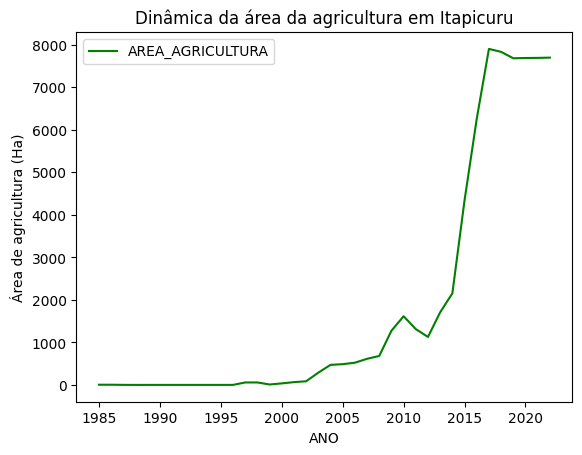

In [44]:
dados_tendencia = dados_tendencia_agricultura()
plot_tendencia(dados_tendencia)

## Séries temporal para previsão de nova área previsão da nova área total destinada a agricultura

In [34]:
def timeseries_to_supervised(df, n_features, n_target):
        n_linhas = 0
        colunas_features = ['var(t - {})'.format(str(i)) for i in range(n_features, -1, -1) if i != 0]
        colunas_target = ['var(t)' if i==0 else 'var(t + {})'.format(str(i)) for i in range(0, n_target)]
        colunas_total = colunas_features + colunas_target
        lista=[]
        
        while n_linhas <= len(df) - n_target - n_features:
            quantidade_de_features_iteracao = df.iloc[n_linhas:n_linhas + n_features].values
            quantidade_de_target_iteracao = df.iloc[n_linhas + n_features: n_linhas + n_features + n_target]
            
            linha = np.concatenate([quantidade_de_features_iteracao, quantidade_de_target_iteracao], axis=0)
            linha_reshape = linha.reshape(1, -1)
            lista.append(linha_reshape[0])
    
            n_linhas += 1
        df_iter = pd.DataFrame(lista, columns=colunas_total)
        return df_iter

In [37]:
serie_agricultura_supervised = timeseries_to_supervised(serie_agricultura[["AREA_AGRICULTURA"]], 2, 1)
serie_agricultura_supervised

,var(t - 2),var(t - 1),var(t)
0,4.566366,4.566366,1.053758
1,4.566366,1.053758,0.000000
2,1.053758,0.000000,0.702508
3,0.000000,0.702508,0.702508
4,0.702508,0.702508,0.702508
5,0.702508,0.702508,0.702508
6,0.702508,0.702508,0.702508
7,0.702508,0.702508,0.702508
8,0.702508,0.702508,0.702508
9,0.702508,0.702508,0.702508


### Preprocessamento

In [ ]:
X = serie_agricultura_supervised.iloc[:, 0:-1]
y = serie_agricultura_supervised.iloc[:, -1]

X_train = X[0:round(0.6*len(X))]
y_train = y[0:round(0.6*len(X))]

X_test = X[round(0.6*len(X)):]
y_test = y[round(0.6*len(X)):]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

### 1) Regressão Linear

In [82]:
modelo_linear = LinearRegression()
modelo_linear.fit(X_train, y_train)

LinearRegression()

In [83]:
y_pred = modelo_linear.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")

Mean squared error: 533648.4712351083
Root mean squared error: 730.5124716492583


In [92]:

input = np.array([7688.363295, 7694.679164]).reshape(1, -1)
input_trans = scaler.transform(input)
y_pred_2023 = modelo_linear.predict(input_trans)
y_pred_2023

array([8067.33804439])

### 2) ARIMA

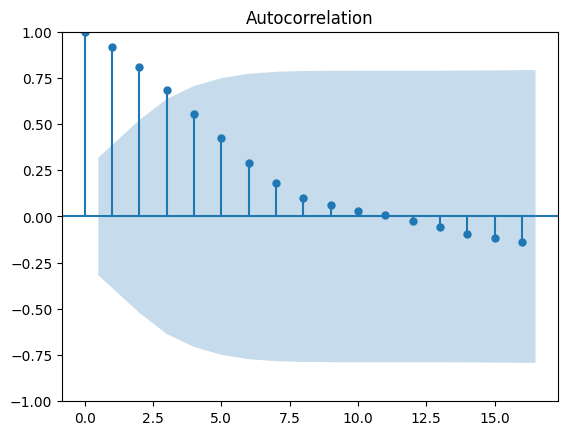

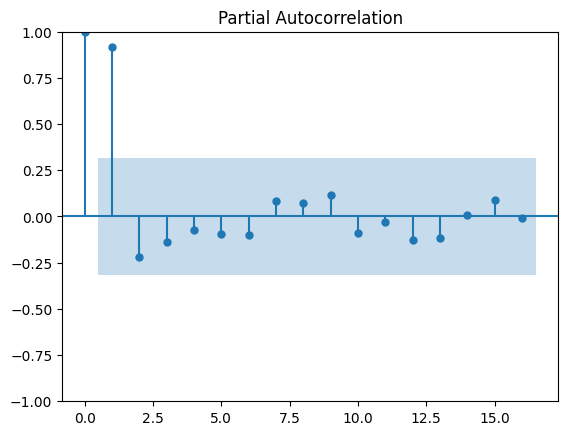

In [63]:
plot_acf(serie_agricultura[["AREA_AGRICULTURA"]])
plot_pacf(serie_agricultura[["AREA_AGRICULTURA"]])
plt.show()

In [96]:
# Crie e ajuste um modelo ARIMA
model = sm.tsa.arima.ARIMA(serie_agricultura['AREA_AGRICULTURA'], order=(1,0,0))
modelo_arima_fit = model.fit()

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [97]:
previsoes = modelo_arima_fit.forecast(steps=3)
previsoes

1970-01-01 00:00:00.000002023    7631.805686
1970-01-01 00:00:00.000002024    7569.606722
1970-01-01 00:00:00.000002025    7508.075037
Freq: N, Name: predicted_mean, dtype: float64

### 3) Rede neural Recorrente

In [119]:
# Crie um modelo de RNN simples

periodos = 2
modelo_rnn = Sequential()
modelo_rnn.add(SimpleRNN(64, activation='relu', input_shape=(periodos, 1)))
modelo_rnn.add(Dense(1))

# Compile o modelo
modelo_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Reshape os dados para o formato de entrada da RNN
X_train_rnn = X_train.reshape(X_train.shape[0], periodos, 1)
X_test_rnn = X_test.reshape(X_test.shape[0], periodos, 1)

In [120]:
# Treine o modelo
modelo_rnn.fit(X_train_rnn, y_train, epochs=100, batch_size=1)

# Faça previsões
ultimos_valores = serie_agricultura_supervised[-periodos:]  # Últimos 'periodos' valores observados

Epoch 1/100


22/22 [==============================] - 1s 2ms/step - loss: 76143.4688
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 76037.0625
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 75922.1094
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 75785.4375
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 75562.9453
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 75265.5625
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 74947.3828
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 74373.7812
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 73743.3906
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 72853.7188
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 71872.2891
Epoch 12/100
22/22 [==============================] - 0s 4ms/step - loss: 70568.5703
E

In [123]:
y_pred = modelo_rnn.predict(X_test_rnn)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")

1/1 [==============================] - 0s 59ms/step
Mean squared error: 2543308.2544762758
Root mean squared error: 1594.7752990550975


In [122]:
# Previsão de 2023 segundo o RNN:
input_rnn = X_test[-1].reshape(1, periodos, 1)
pred = modelo_rnn.predict(input_rnn)
pred


1/1 [==============================] - 0s 27ms/step


array([[8252.107]], dtype=float32)

## Análise de transição

In [3]:
transicoes_municipais_raw = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                      sheet_name="TRANSICOES_COL8.0")

In [88]:
transicoes_df = transicoes_municipais_raw.copy()
transicoes_df.head()

,feature_id,biome,municipality,state_acronym,geocode,biome [municipality],class_id_to,level_1_id_to,level_2_id_to,level_3_id_to,...,2015-2016,2015-2020,2016-2017,2016-2022,2017-2018,2018-2019,2018-2022,2019-2020,2020-2021,2021-2022
0,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,393108.346771,375299.476204,390452.564163,362080.507020,386982.729188,381548.907517,362424.195116,376968.720871,372147.859587,363759.169172
1,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,1.835615,3.234690,NaN,0.524438,NaN,NaN,NaN,NaN,NaN,NaN
2,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,4.545471,8.474783,4.279844,17.027974,2.178572,0.786912,18.612014,7.940119,3.497145,39.717964
3,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,NaN,1.834875,NaN,6.908685,0.612750,0.610068,6.643013,0.524683,0.524873,5.243668
4,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,427.453779,1848.489791,396.000144,1692.881132,201.152782,322.922978,1085.080697,218.242734,101.165963,420.252587


In [89]:
transicoes_df.drop(columns=["biome [municipality]", "municipality", "biome", 
                            "feature_id", "state_acronym", "from_color",
                            "to_class", "class_id_to", "to_level_1", "from_level_1",
                            'level_1_id_from', 'level_2_id_from', 'level_3_id_from',
                            'level_1_id_to', 'level_2_id_to',
                            'level_3_id_to', 'level_4_id_to','class_id_from',
                            'to_level_3', 'to_level_4',
                            'to_color', 'level_4_id_from', 
                            'from_level_0', 'from_level_3', 'from_level_4', 
                            'from_class', 'to_level_0'], inplace=True)

transicoes_df.rename(columns={"geocode":"IBGE7"}, inplace=True)
transicao_cidade = transicoes_df[transicoes_df["IBGE7"] == 2916500]

In [90]:
condicao_agricultura = (transicao_cidade["to_level_2"] == "Agriculture")|(transicao_cidade["to_level_2"] == "Mosaic of Agriculture and Pasture")
transicao_cidade_agricultura = transicao_cidade[condicao_agricultura].reset_index(drop=True)
transicao_cidade_agricultura_melted = transicao_cidade_agricultura.melt(id_vars=["IBGE7", 
                                                                          "to_level_2", 
                                                                          "from_level_2"], 
                                                                          value_name="AREA_TRANSICAO",
                                                                          value_vars="1985-2022")

In [92]:
agrupado = transicao_cidade_agricultura_melted.groupby(by="from_level_2")[["AREA_TRANSICAO"]].sum()
agrupado["AREA_TRANSICAO_MEDIA_ANUAL"] = agrupado["AREA_TRANSICAO"] / 38
agrupado

,AREA_TRANSICAO,AREA_TRANSICAO_MEDIA_ANUAL
from_level_2,,
Agriculture,1.492887,0.039286
Forest Formation,967.998018,25.473632
Forest Plantation,0.000000,0.000000
Grassland,64.383974,1.694315
Mosaic of Agriculture and Pasture,6066.919045,159.655764
Other Non Vegetated Area,25.625046,0.674343
Pasture,8370.451930,220.275051
"River, Lake and Ocean",6.228878,0.163918
Savanna Formation,2817.003901,74.131682


## Barplot stacked

In [21]:
def dados_para_plot(id_municipio=2916500):
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                          sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "municipality", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2"])[list(range(1985, 2023))].sum().reset_index()
    
    biomas_lista = ["Forest Formation", "Mosaic of Agriculture and Pasture", "Pasture", "Savanna Formation"]
    lista_Anos = list(range(2010, 2022))
    biomas_serem_explorados = biomas_agrupados[(biomas_agrupados["IBGE7"] == id_municipio)&(biomas_agrupados["level_2"].isin(biomas_lista))]
    biomas_serem_explorados = biomas_serem_explorados.melt(id_vars=["IBGE7", "level_2"], var_name="ANO", value_name="AREA_HECTAR")
    biomas_serem_explorados = biomas_serem_explorados[biomas_serem_explorados["ANO"].isin(lista_Anos)]
    return biomas_serem_explorados


def plot_stacked_bar(biomas_serem_explorados):
    pivot_df = biomas_serem_explorados.drop(columns="IBGE7").pivot(index='ANO', columns='level_2', values='AREA_HECTAR')
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    ax = pivot_df_percent.plot(kind='bar', stacked=True, figsize=(15, 5))
    sns.set_style(None)
    ax.legend().set_visible(False)
    ax.set_xlabel(None)
    plt.ylabel('% de área')
    plt.xticks(rotation=0)
    plt.title('Distribuição das coberturas mais indicadas para transição para Agricultura')
    plt.show()